# Initial Command

In [60]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


# Imports and Load Data

In [61]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams.update({"font.size": 12})
sns.set(style="white", color_codes=True, rc={"figure.figsize": (14, 6)}, palette="deep")

from typing import List, Dict

In [62]:
house_price = catalog.load('house_price')

[01/14/24 14:31:12] INFO     Loading data from house_price (CSVDataset)...                      ]8;id=312519;file://C:\Users\paulo.santos\AppData\Local\anaconda3\envs\house_price\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=71839;file://C:\Users\paulo.santos\AppData\Local\anaconda3\envs\house_price\Lib\site-packages\kedro\io\data_catalog.py#482\482]8;;\

# Data processing


## Summary View

In [63]:
house_price

,logradouro,numero,bairro,cep,cidade,tipo_de_imovel,area_util,banheiros,suites,quartos,vagas_garagem,anuncio_criado,tipo_anuncio,preco_venda,taxa_condominio,periodicidade,preco_aluguel,iptu_ano
0,Rua Juvenal Galeno,53,Jardim da Saúde,4290030.0,São Paulo,Casa de dois andares,388.0,3.0,1.0,4.0,6.0,2017-02-07,Venda,700000,NaN,NaN,NaN,NaN
1,Rua Juruaba,16,Vila Santa Teresa (Zona Sul),4187320.0,São Paulo,Casa,129.0,2.0,1.0,3.0,2.0,2016-03-21,Venda,336000,NaN,NaN,NaN,NaN
2,Avenida Paulista,402,Bela Vista,1311000.0,São Paulo,Comercial,396.0,4.0,0.0,0.0,5.0,2018-12-18,Locação,24929,4900.0,MONTHLY,29829.0,4040.0
3,Rua Alvorada,1190,Vila Olímpia,4550004.0,São Paulo,Apartamento,80.0,2.0,1.0,3.0,2.0,2018-10-26,Venda,739643,686.0,NaN,NaN,1610.0
4,Rua Curitiba,380,Paraíso,4005030.0,São Paulo,Apartamento,3322.0,5.0,4.0,4.0,5.0,2018-12-14,Venda,7520099,6230.0,NaN,NaN,18900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133959,Rua Glicério,255,Liberdade,1514000.0,São Paulo,Apartamento,53.0,2.0,1.0,2.0,1.0,2018-11-28,Venda,249782,210.0,NaN,NaN,0.0
133960,Rua Laboriosa,NaN,Jardim das Bandeiras,5434060.0,São Paulo,Escritório,450.0,3.0,1.0,3.0,4.0,2018-08-08,Venda,1085000,NaN,NaN,NaN,507.0
133961,Rua José Pereira de Carvalho,10,Vila Lageado,5337090.0,São Paulo,Apartamento,20.0,3.0,2.0,3.0,2.0,2019-02-06,Venda,623000,NaN,NaN,NaN,NaN
133962,Rua Evangelista Rodrigues,234,Alto de Pinheiros,5463000.0,São Paulo,Casa de dois andares,357.0,4.0,1.0,4.0,4.0,2018-04-14,Venda,1820000,0.0,NaN,NaN,665.0


In [64]:
house_price.dtypes


logradouro          object
numero              object
bairro              object
cep                float64
cidade              object
tipo_de_imovel      object
area_util          float64
banheiros          float64
suites             float64
quartos            float64
vagas_garagem      float64
anuncio_criado      object
tipo_anuncio        object
preco_venda          int64
taxa_condominio    float64
periodicidade       object
preco_aluguel      float64
iptu_ano           float64
dtype: object

## Selection and Renaming of variables

In [65]:
def filter_columns(dataframe: pd.DataFrame, select_columns: List[str]) -> pd.DataFrame:
    """
    Filters the columns of the DataFrame that are present in the desired_columns list.

    Parameters:
    - dataframe: The original DataFrame.
    - select_columns: List of column names to be kept in the resulting DataFrame.

    Returns:
    - A new DataFrame containing only the desired columns.
    """
    return dataframe[select_columns]

In [66]:
def rename_columns(dataframe: pd.DataFrame, column_mapping: Dict[str, str]) -> pd.DataFrame:
    """
    Renames columns of the DataFrame based on the provided column_mapping dictionary.

    Parameters:
    - dataframe: The original DataFrame.
    - column_mapping: A dictionary where keys are current column names and values are the new names.

    Returns:
    - A new DataFrame with renamed columns.
    """
    return dataframe.rename(columns=column_mapping)

In [67]:
select_columns=['tipo_de_imovel','area_util','banheiros','suites','quartos','vagas_garagem','tipo_anuncio','preco_venda']
house_price_filtered = filter_columns(dataframe=house_price, select_columns=select_columns)

column_mapping={'tipo_de_imovel':'property','area_util':'useful_area','banheiros':'bathroom',
                'suites':'suite','quartos':'bedroom','vagas_garagem':'garage','tipo_anuncio':'ad',
                'preco_venda':'price'}
house_price_filtered = rename_columns(dataframe=house_price_filtered, column_mapping=column_mapping)

house_price_filtered.head(2)

,property,useful_area,bathroom,suite,bedroom,garage,ad,price
0,Casa de dois andares,388.0,3.0,1.0,4.0,6.0,Venda,700000
1,Casa,129.0,2.0,1.0,3.0,2.0,Venda,336000


## Renaming categories

### Property

In [68]:
house_price_filtered['property'].unique()


array(['Casa de dois andares', 'Casa', 'Comercial', 'Apartamento', 'Flat',
       'Condomínio', 'Depósito', 'Loteamento Residencial', 'Cobertura',
       'Loja', 'Prédio Residencial', 'Escritório', 'Loteamento Comercial',
       'Kitnet', 'Prédio Comercial', 'Clínica', 'Casa de Campo',
       'Fazenda'], dtype=object)

In [69]:
property_mapping = {'Casa de dois andares':'residential', 'Casa':'residential', 'Comercial':'commercial', 'Apartamento':'residential', 'Flat':'residential',
       'Condomínio':'residential', 'Depósito':'commercial', 'Loteamento Residencial':'residential', 'Cobertura':'residential',
       'Loja':'commercial', 'Prédio Residencial':'residential', 'Escritório':'commercial', 'Loteamento Comercial':'commercial',
       'Kitnet':'residential', 'Prédio Comercial':'commercial', 'Clínica':'commercial', 'Casa de Campo':'residential',
       'Fazenda':'residential'}



In [70]:
def map_categories(dataframe: pd.DataFrame, column_name: str, category_mapping: Dict[str, str]) -> pd.DataFrame:
    """
    Maps categories in a specific column of the DataFrame based on the provided category_mapping dictionary.

    Parameters:
    - dataframe: The original DataFrame.
    - column_name: The name of the column with categories to be mapped.
    - category_mapping: A dictionary where keys are current category values and values are the new category values.

    Returns:
    - A new DataFrame with the specified column's categories mapped.
    """
    dataframe_copy = dataframe.copy()  # Create a copy to avoid modifying the original DataFrame
    dataframe_copy[column_name] = dataframe_copy[column_name].map(category_mapping)
    return dataframe_copy

In [71]:
house_price_filtered = map_categories(dataframe=house_price_filtered, column_name='property', category_mapping=property_mapping)
house_price_filtered

,property,useful_area,bathroom,suite,bedroom,garage,ad,price
0,residential,388.0,3.0,1.0,4.0,6.0,Venda,700000
1,residential,129.0,2.0,1.0,3.0,2.0,Venda,336000
2,commercial,396.0,4.0,0.0,0.0,5.0,Locação,24929
3,residential,80.0,2.0,1.0,3.0,2.0,Venda,739643
4,residential,3322.0,5.0,4.0,4.0,5.0,Venda,7520099
...,...,...,...,...,...,...,...,...
133959,residential,53.0,2.0,1.0,2.0,1.0,Venda,249782
133960,commercial,450.0,3.0,1.0,3.0,4.0,Venda,1085000
133961,residential,20.0,3.0,2.0,3.0,2.0,Venda,623000
133962,residential,357.0,4.0,1.0,4.0,4.0,Venda,1820000


### Ad

In [72]:
house_price_filtered['ad'].unique()

array(['Venda', 'Locação'], dtype=object)

In [73]:
ad_mapping = {'Venda':'sale', 'Locação':'rental'}

In [74]:
house_price_filtered = map_categories(dataframe=house_price_filtered, column_name='ad', category_mapping=ad_mapping)
house_price_filtered

,property,useful_area,bathroom,suite,bedroom,garage,ad,price
0,residential,388.0,3.0,1.0,4.0,6.0,sale,700000
1,residential,129.0,2.0,1.0,3.0,2.0,sale,336000
2,commercial,396.0,4.0,0.0,0.0,5.0,rental,24929
3,residential,80.0,2.0,1.0,3.0,2.0,sale,739643
4,residential,3322.0,5.0,4.0,4.0,5.0,sale,7520099
...,...,...,...,...,...,...,...,...
133959,residential,53.0,2.0,1.0,2.0,1.0,sale,249782
133960,commercial,450.0,3.0,1.0,3.0,4.0,sale,1085000
133961,residential,20.0,3.0,2.0,3.0,2.0,sale,623000
133962,residential,357.0,4.0,1.0,4.0,4.0,sale,1820000


## NA Verification

In [75]:
def count_na_stats(dataframe: pd.DataFrame) -> tuple:
    """
    Counts the number of NA values in each column and the number of rows with at least one NA value in the DataFrame.

    Parameters:
    - dataframe: The DataFrame to be analyzed.

    Returns:
    - A tuple containing two elements:
        - A pandas Series with the count of NA values for each column.
        - An integer representing the count of rows with NA values.
    """
    na_counts_per_column = dataframe.isna().sum()
    na_rows_count = dataframe.isna().any(axis=1).sum()
    return na_counts_per_column, na_rows_count

In [76]:
na_stats_result = count_na_stats(house_price_filtered)
na_counts_per_column, na_rows_count = na_stats_result

print("Counts of NA values per column:")
print(na_counts_per_column)

print("\nNumber of rows with at least one NA value:")
print(na_rows_count)

Counts of NA values per column:
property           0
useful_area     3096
bathroom         913
suite          13617
bedroom         3019
garage          4425
ad                 0
price              0
dtype: int64

Number of rows with at least one NA value:
17198


In [77]:
def drop_na_rows(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Drops rows with NA values from the DataFrame.

    Parameters:
    - dataframe: The DataFrame to be processed.

    Returns:
    - A new DataFrame with rows containing NA values removed.
    """
    dataframe_without_na = dataframe.dropna()
    return dataframe_without_na

In [78]:
house_price_without_na = drop_na_rows(house_price_filtered)
house_price_without_na = filter_columns(dataframe=house_price_without_na, 
                                        select_columns=['useful_area', 'bathroom', 'suite', 'bedroom', 'garage','price'])

Renaming of the database that will be used in graphical analysis

In [79]:
hp_data = house_price_without_na.copy()

# Statistical analysis

## Univariate analysis


In [80]:
def summary_statistics(dataframe: pd.DataFrame) -> dict:
    """
    Computes summary statistics for numeric columns and category counts for categorical columns in the DataFrame.

    Parameters:
    - dataframe: The DataFrame to be analyzed.

    Returns:
    - A dictionary containing summary statistics:
      {
        'numeric_quartiles': DataFrame with quartiles for numeric columns,
        'category_counts': DataFrame with counts for each category in categorical columns
      }
    """
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    category_columns = dataframe.select_dtypes(include=['object', 'category']).columns

    # Summary statistics for numeric columns
    numeric_quartiles = dataframe[numeric_columns].describe(percentiles=[0.25, 0.5, 0.75])

    # Category counts for categorical columns
    category_counts = pd.DataFrame()
    for column in category_columns:
        category_counts[column] = dataframe[column].value_counts()

    result_dict = {
        'numeric_quartiles': numeric_quartiles,
        'category_counts': category_counts
    }

    return result_dict

In [81]:
summary_stats_result = summary_statistics(hp_data)

print("Numeric Quartiles:")
print(summary_stats_result['numeric_quartiles'])

print("\nCategory Counts:")
print(summary_stats_result['category_counts'])

Numeric Quartiles:
        useful_area       bathroom          suite        bedroom  \
count  1.167660e+05  116766.000000  116766.000000  116766.000000   
mean   2.233514e+02       2.460314       1.121748       2.377653   
std    6.047520e+03       2.113711       1.213984       2.219531   
min    1.000000e+00       0.000000       0.000000       0.000000   
25%    6.500000e+01       1.000000       0.000000       2.000000   
50%    1.120000e+02       2.000000       1.000000       3.000000   
75%    2.000000e+02       3.000000       2.000000       3.000000   
max    2.025000e+06     200.000000      80.000000     600.000000   

              garage         price  
count  116766.000000  1.167660e+05  
mean        2.463645  6.948812e+05  
std         4.981696  1.321171e+06  
min         0.000000  7.000000e+01  
25%         1.000000  1.890000e+05  
50%         2.000000  3.941000e+05  
75%         3.000000  7.700000e+05  
max       589.000000  8.400000e+07  

Category Counts:
Empty DataFrame
C

Filtering outliers in the database and categorical variables

In [82]:
def remove_outliers(dataframe: pd.DataFrame, lower_percentile: float = 0.05, upper_percentile: float = 0.95) -> pd.DataFrame:
    """
    Removes outliers from numeric columns in the DataFrame based on the specified percentiles.

    Parameters:
    - dataframe: The DataFrame to be processed.
    - lower_percentile: The lower percentile (default is 1%).
    - upper_percentile: The upper percentile (default is 99%).

    Returns:
    - A new DataFrame with outliers removed.
    """
    numeric_columns = dataframe.select_dtypes(include=['number']).columns

    for column in numeric_columns:
        lower_limit = dataframe[column].quantile(lower_percentile)
        upper_limit = dataframe[column].quantile(upper_percentile)

        dataframe = dataframe[(dataframe[column] >= lower_limit) & (dataframe[column] <= upper_limit)]

    return dataframe

In [83]:
def filter_dataframe(df: pd.DataFrame, conditions: dict) -> pd.DataFrame:
    """
    Filters rows in the DataFrame based on specified conditions for multiple columns.

    Parameters:
    - df: The DataFrame to be filtered.
    - conditions: A dictionary where keys are column names, and values are the desired values for those columns.

    Returns:
    - A new DataFrame with rows filtered based on the specified conditions.
    """
    condition_mask = pd.Series([True] * len(df), index=df.index)

    for column, value in conditions.items():
        condition_mask &= (df[column] == value)

    filtered_df = df[condition_mask]
    return filtered_df

In [84]:
conditions = {'property': 'residential', 'ad': 'sale'}

hp_data_no_outliers = remove_outliers(dataframe=hp_data, lower_percentile=0.05, upper_percentile=0.95)
hp_data_no_outliers = filter_dataframe(hp_data, conditions)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\paulo.santos\AppData\Local\anaconda3\envs\house_price\Lib\site-packages\pandas\core\ind │
│ exes\base.py:3791 in get_loc                                                                     │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:152                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:181                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7080                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7088                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'property'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 conditions = {'property': 'residential', 'ad': 'sale'}                                       │
│   2                                                                                              │
│   3 hp_data_no_outliers = remove_outliers(dataframe=hp_data, lower_percentile=0.05, upper_pe     │
│ ❱ 4 hp_data_no_outliers = filter_dataframe(hp_data, conditions)                                  │
│   5                                                                                              │
│                                                                                                  │
│ in filter_dataframe:15                                                                           │
│                                                                                                  │
│   12 │   condition_mask = pd.Series([True] * len(df), index=df.index)                            │
│   13 │                                                                                           │
│   14 │   for column, value in conditions.items():                                                │
│ ❱ 15 │   │   condition_mask &= (df[column] == value)                                             │
│   16 │                                                                                           │
│   17 │   filtered_df = df[condition_mask]                                                        │
│   18 │   return filtered_df                                                                      │
│                                                                                                  │
│ C:\Users\paulo.santos\AppData\Local\anaconda3\envs\house_price\Lib\site-packages\pandas\core\fra │
│ me.py:3893 in __getitem__                                                                        │
│                                                                                                  │
│ C:\Users\paulo.santos\AppData\Local\anaconda3\envs\house_price\Lib\site-packages\pandas\core\ind │
│ exes\base.py:3798 in get_loc                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'property'

In [85]:
summary_stats_result_no_outliers = summary_statistics(hp_data_no_outliers)

print("Numeric Quartiles:")
print(summary_stats_result_no_outliers['numeric_quartiles'])

print("\nCategory Counts:")
print(summary_stats_result_no_outliers['category_counts'])

Numeric Quartiles:
        useful_area      bathroom         suite       bedroom        garage  \
count  83779.000000  83779.000000  83779.000000  83779.000000  83779.000000   
mean     120.047542      2.166247      0.946920      2.386827      1.729550   
std       75.039703      1.256360      0.905651      0.977361      1.004431   
min       37.000000      0.000000      0.000000      0.000000      0.000000   
25%       65.000000      1.000000      0.000000      2.000000      1.000000   
50%      100.000000      2.000000      1.000000      3.000000      2.000000   
75%      150.000000      3.000000      1.000000      3.000000      2.000000   
max      500.000000      5.000000      3.000000      4.000000      4.000000   

              price  
count  8.377900e+04  
mean   4.668309e+05  
std    3.449506e+05  
min    2.033000e+03  
25%    2.379990e+05  
50%    3.954300e+05  
75%    6.300000e+05  
max    1.603000e+06  

Category Counts:
Empty DataFrame
Columns: []
Index: []


# Bivariate analysis


In [88]:
def correlation_matrix(dataframe: pd.DataFrame, method='pearson'):
    """
    Generates a correlation matrix and heatmap for numeric variables in the DataFrame using Seaborn.

    Parameters:
    - dataframe: The DataFrame to be analyzed.
    - method: The correlation method to use ('pearson' or 'spearman').

    """
    numeric_columns = dataframe.select_dtypes(include=['number']).columns

    # Calculate correlation matrix
    correlation_matrix = dataframe[numeric_columns].corr(method=method)

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Matrix ({method.capitalize()})')
    plt.show()


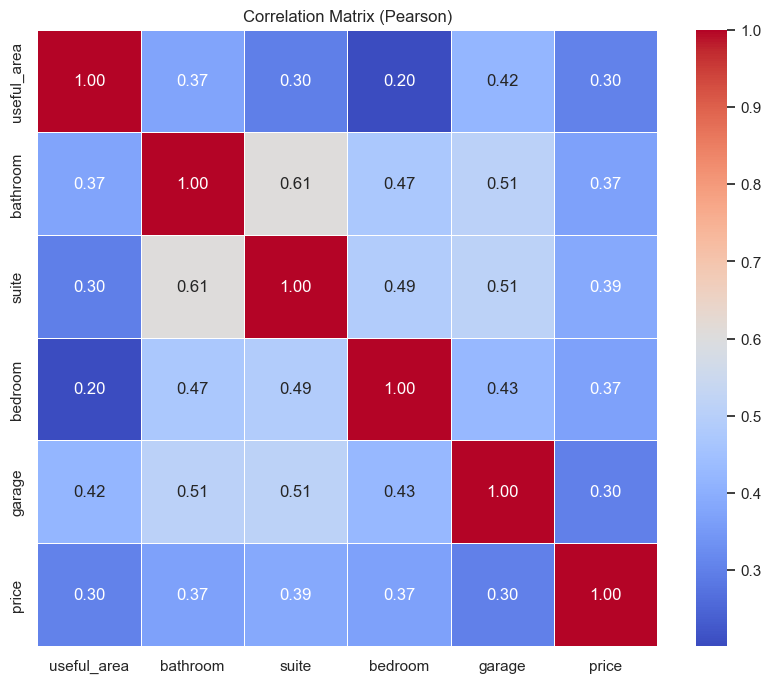

In [89]:
correlation_matrix(hp_data_no_outliers, method='pearson')

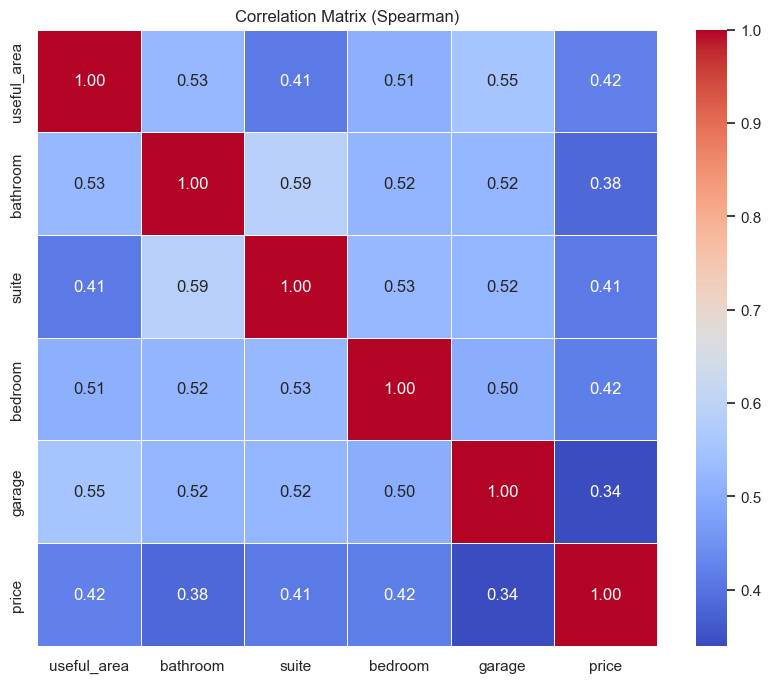

In [90]:
correlation_matrix(hp_data_no_outliers, method='spearman')